In [1]:
from pathlib import Path
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer

from skopt import BayesSearchCV
from skopt.plots import plot_objective

from detector import detect_everything
from evaluate import read_data, eval_onsets

import json

import mir_eval

C:\Users\chris\anaconda3\envs\music\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DummyOptions():
    def __init__(self, mfs, w1, w2, w3, w4, w5, delta):
        self.mfs = mfs
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5
        self.delta = delta
        self.plot = False

In [3]:
class Detector(BaseEstimator):
    def __init__(self, mfs=2, w1=10, w2=10, w3=10, w4=10, w5=0.1, delta=0.1):
        super().__init__()
        self.mfs = mfs
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5
        self.delta = delta
        
    def fit(self, X, Y):
        return self
    
    def predict(self, X):
        options = DummyOptions(self.mfs, self.w1, self.w2, self.w3, self.w4, self.w5, self.delta)
        #return {filename.name.rsplit('.', 1)[0]: detect_everything(filename, options) for filename in X}
        return [detect_everything(filename, options)['onsets'] for filename in X]

In [4]:
def scorer(estimator, X, y):
    preds = estimator.predict(X)
    return sum(mir_eval.onset.f_measure(np.asarray(y[k]),
                                        np.asarray(preds[k]),
                                        0.05)[0]
               for k in range(len(y))) / len(y)

In [4]:
source_dir = 'val'

In [5]:
indir = Path(source_dir)
infiles = list(indir.glob('*.wav'))

In [6]:
truth_full = read_data(source_dir, extension='.gt')

In [7]:
truth = []
for filename in infiles:
    truth.append(truth_full[filename.name.rsplit('.', 1)[0]]['onsets'])

In [8]:
len(truth) == len(infiles), len(truth)

(True, 150)

In [10]:
class ProgressBar():
    def __init__(self, total):
        self.progress_bar = tqdm(total=total)
        
    def __call__(self, result):
        self.progress_bar.update()
        self.progress_bar.set_postfix({'Best Score': -result.fun})
    
    def close(self):
        self.progress_bar.close()

In [11]:
search_space = {
    'mfs': (1, 10),
    'w1': (3, 50),
    'w2': (3, 50),
    'w3': (3, 50),
    'w4': (3, 50),
    'w5': (0.01, 0.5),
    'delta': (0.,0.5)
}

In [12]:
n_iter = 500
n_jobs = 7

search = BayesSearchCV(Detector(),
                       search_space,
                       scoring=scorer,
                       n_iter=n_iter,
                       n_jobs=n_jobs,
                       n_points=n_jobs,
                       refit=False,
                       random_state=42,
                       cv=[([], list(range(len(infiles))))]) # no training data, all in validation

search.fit(infiles, truth, callback=ProgressBar(int(np.ceil(n_iter/n_jobs))))

print("best score: %s" % search.best_score_)
print("best params: %s" % str(search.best_params_))

100%|█████████████████████████████████████████████████████████████| 72/72 [2:25:27<00:00, 450.62s/it, Best Score=0.778]

best score: 0.7775068935003954
best params: OrderedDict([('delta', 0.08216509071402968), ('mfs', 1), ('w1', 3), ('w2', 4), ('w3', 3), ('w4', 11), ('w5', 0.015561185875022171)])


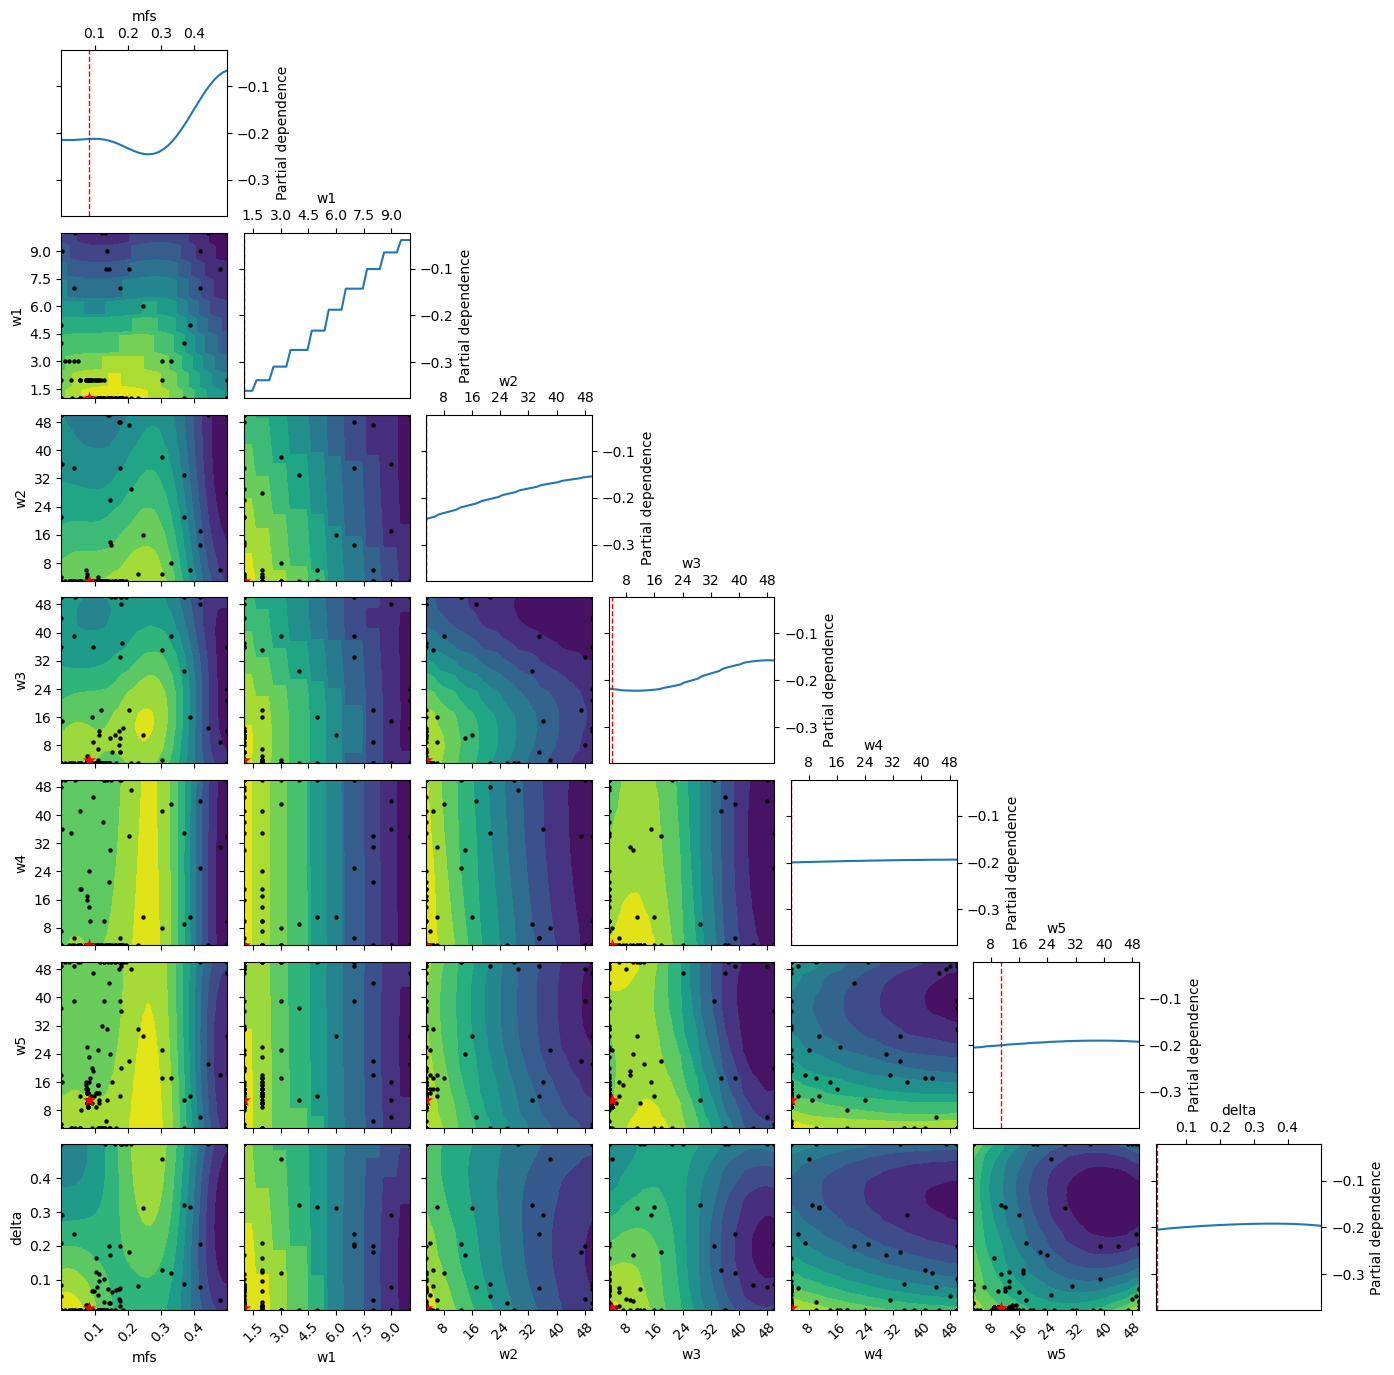

In [13]:
_ = plot_objective(search.optimizer_results_[0],
                   dimensions=list(search_space.keys()),
                   n_minimum_search=int(1e8))
plt.show()

In [3]:
source_dir = 'train'
indir = Path(source_dir)
infiles = list(indir.glob('*.wav'))
truth_full = read_data(source_dir, extension='.gt')
truth = []
for filename in infiles:
    truth.append(truth_full[filename.name.rsplit('.', 1)[0]])

In [4]:
params = dict([('delta', 0.0639348884241159), ('mfs', 2), ('w1', 3), ('w2', 5), ('w3', 3), ('w4', 17), ('w5', 0.03985417509689619)])
options = DummyOptions(**params)
#detector = Detector(**params)

In [5]:
preds = [detect_everything(filename, options) for filename in infiles]

In [203]:
index = 2
pred_onsets = preds[index]['onsets']
pred_tempi = preds[index]['tempo']
pred_odf = preds[index]['beats']

In [199]:
def make_pulse_train(tempo, phase=0, length=70*3, pulse_width=5, fps=70):
    return (np.arange(-phase,length-phase) % (60*fps/tempo) < pulse_width).astype(float)

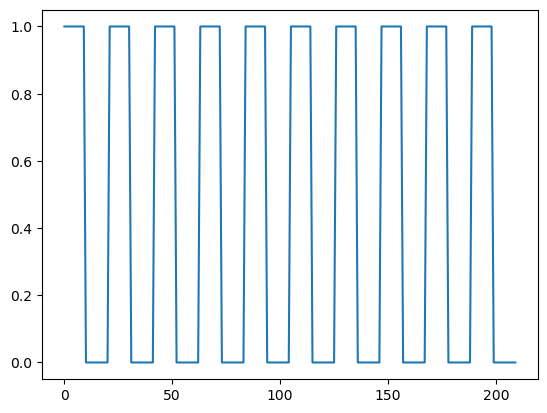

In [99]:
plt.plot(make_pulse_train(200))

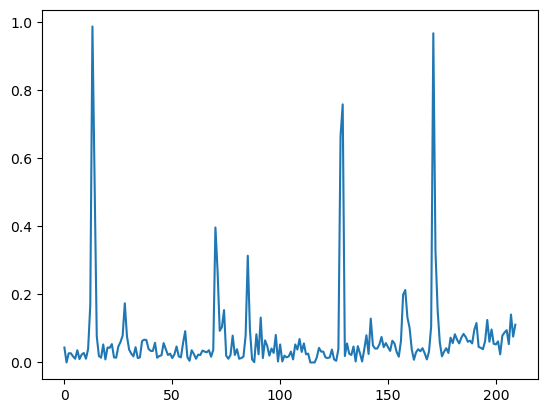

In [33]:
plt.plot(pred_odf[:70*3])

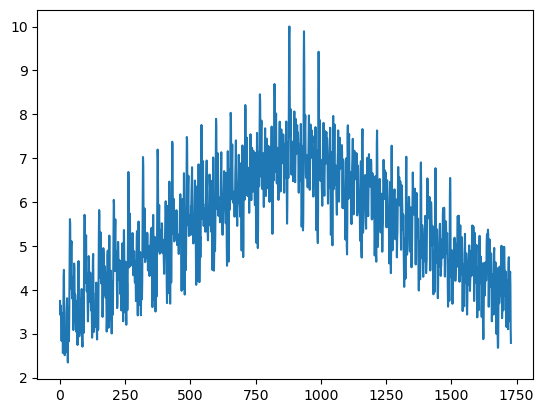

In [80]:
plt.plot(np.correlate(pred_odf, make_pulse_train(pred_tempi[0], length=len(pred_odf)), 'same'))

In [219]:
def get_phase_and_correlation(odf, tempo, pulse_width=5, fps=70):
    filtered_odf = np.array(odf.copy())
    filtered_odf[filtered_odf < np.median(filtered_odf)] = 0
    corr = np.correlate(filtered_odf, make_pulse_train(tempo, length=len(odf), pulse_width=pulse_width, fps=fps), 'same')
    mid = int(np.ceil(len(corr)/2))
    phase = corr[mid:].argmax()
    return phase, corr[mid:][phase]

In [220]:
def choose_tempo_and_phase(odf, tempi, pulse_width=5, fps=70):
    phase1, corr1 = get_phase_and_correlation(odf, tempi[0], pulse_width=pulse_width, fps=fps)
    phase2, corr2 = get_phase_and_correlation(odf, tempi[1], pulse_width=pulse_width, fps=fps)
    if corr2 > 2 * corr1:
        return tempi[1], phase2
    return tempi[0], phase1

In [221]:
tempo, phase = choose_tempo_and_phase(pred_odf, pred_tempi)

16 13.52 9 25.999000000000002


16 13.52 9 25.999000000000002


31 11.736 9 22.346


In [222]:
pulse_width = 5
threshold = 60/tempo/3
beats = []
pred_onsets = np.asarray(pred_onsets)
for beat in np.arange(phase, len(pred_odf), (60*70/tempo)):
    beat_middle = (beat+pulse_width/2)/70
    if len(pred_onsets) != 0:
        nearest_id = np.abs(pred_onsets - beat_middle).argmin()
        nearest = pred_onsets[nearest_id]
    else:
        nearest = -100
    if np.abs(nearest - beat_middle) < threshold:
        beats.append(nearest)
    else:
        beats.append(beat_middle)

In [223]:
mir_eval.beat.f_measure(np.asarray(truth[index]['beats']),
                                       np.asarray(beats),
                                       0.07)

0.625

In [196]:
beats

[0.186,
 1.0,
 1.843,
 2.443,
 3.486,
 4.143,
 5.0,
 5.729,
 6.757,
 7.371,
 8.286,
 9.029,
 10.057,
 10.671,
 11.386,
 12.314,
 12.971,
 13.807142857142857,
 14.714,
 15.414,
 16.229,
 16.857,
 17.843,
 18.571,
 19.4,
 20.329,
 20.943,
 21.971,
 22.671,
 23.4,
 24.229]

(4.0, 7.0)

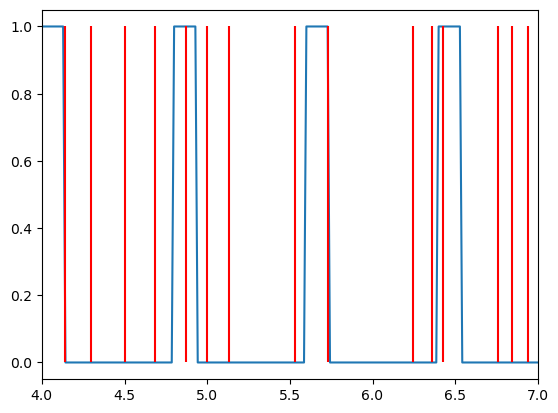

In [ ]:
plt.plot(np.arange(len(pred_odf))/70, make_pulse_train(pred_tempi[0], length=len(pred_odf)))
plt.vlines(pred_onsets, 0, 1, colors='r')
plt.xlim(4, 7)

In [52]:
corr = np.correlate(pred_odf[:70*3], make_pulse_train(pred_tempi[1]), 'same')
initial_phase = (corr>corr.mean()).nonzero()[0][0]

In [55]:
np.correlate(pred_odf, make_pulse_train(pred_tempi[1], initial_phase, len(pred_odf)))

array([14.241])

array([6.98])

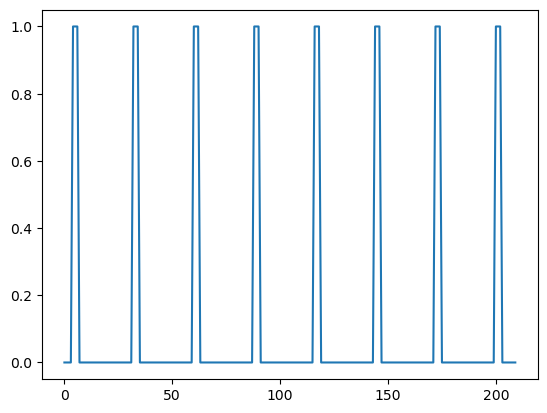

In [54]:
plt.plot(make_pulse_train(pred_tempi[1], initial_phase))

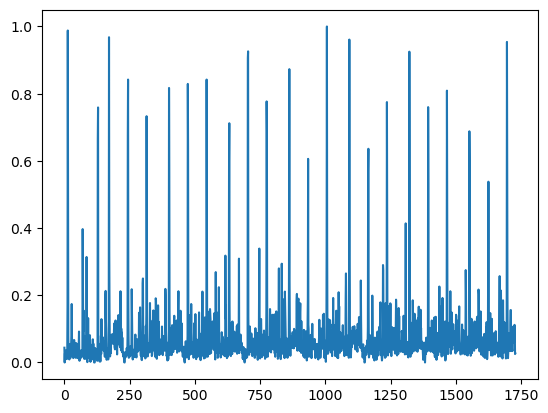

In [12]:
plt.plot(pred_odf)

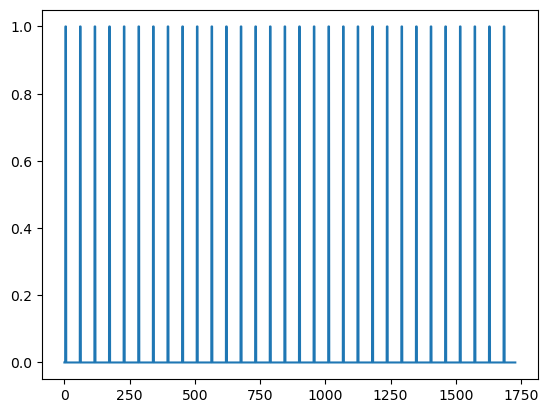

In [57]:
plt.plot(make_pulse_train(pred_tempi[0], initial_phase, len(pred_odf)))

In [5]:
#preds = detector.predict(infiles)
preds = [detect_everything(filename, options)['tempo'] for filename in infiles]

In [133]:
def autocorr(x):
    result = np.correlate(x, x, mode='same')
    mid = int(np.ceil(len(result)/2))
    return result[mid+21:mid+70]

def get_peak(x):
    return (1/(np.argmax(x)+20))*70*60

In [137]:
60*70/200

21.0

In [138]:
index = 4
odf = preds[index]

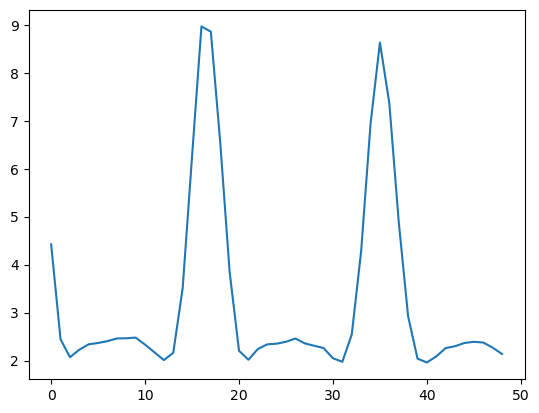

In [139]:
corr = autocorr(odf)
plt.plot(corr)

In [140]:
get_peak(corr)

116.66666666666667

In [141]:
truth[index]['tempo']

[56.2011858015, 112.402371603, 0.1]

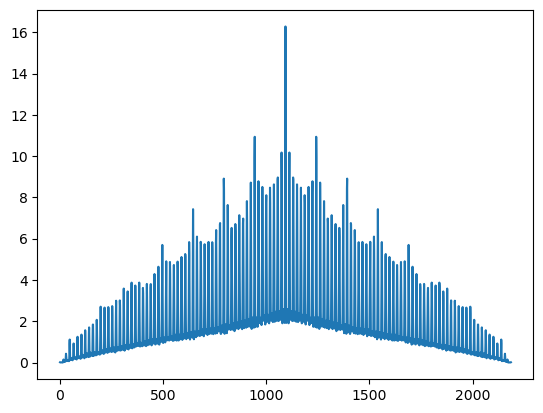

In [131]:
corr = np.correlate(odf, odf, 'full')
plt.plot(corr)

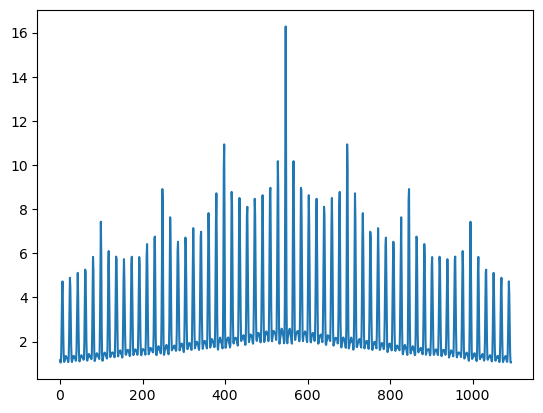

In [130]:
len(corr)

1094

In [24]:
np.convolve()

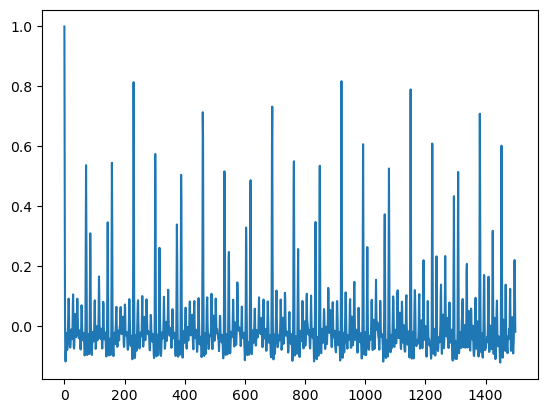

In [24]:
plt.plot(acf(odf, 1500))

In [97]:
len(preds)

127

In [109]:
np.asarray(preds[0])[None, :] - np.asarray(preds[0])[:, None]

array([[  0.   ,   0.214,   0.814, ...,  23.714,  24.043,  24.257],
       [ -0.214,   0.   ,   0.6  , ...,  23.5  ,  23.829,  24.043],
       [ -0.814,  -0.6  ,   0.   , ...,  22.9  ,  23.229,  23.443],
       ...,
       [-23.714, -23.5  , -22.9  , ...,   0.   ,   0.329,   0.543],
       [-24.043, -23.829, -23.229, ...,  -0.329,   0.   ,   0.214],
       [-24.257, -24.043, -23.443, ...,  -0.543,  -0.214,   0.   ]])

In [162]:
index = 7
ioi = (np.asarray(preds[index])[None, :] - np.asarray(preds[index])[:, None])[np.triu_indices(len(preds[index]))]
ioi = ioi[~np.isclose(ioi, 0)]
ioi *= 60
ioi = ioi[(ioi>60)&(ioi<200)]
hist = np.bincount(np.round(ioi).astype(int))

In [163]:
np.flip(np.argsort(hist)[-5:])

array([177, 188, 200, 189,  85], dtype=int64)

In [164]:
truth[index]['tempo']

[39.9206183418, 79.8412366835, 0.1]

<BarContainer object of 201 artists>

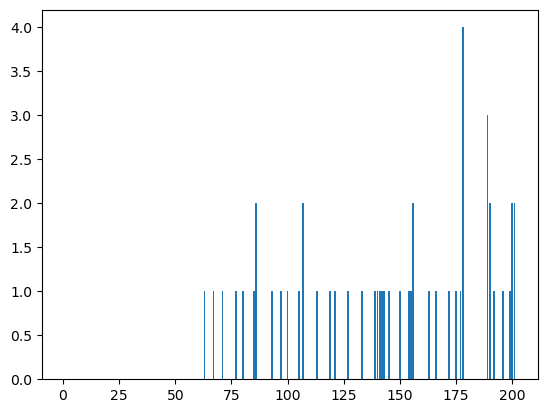

In [165]:
plt.bar(np.arange(1, len(hist)+1), hist)

<BarContainer object of 1000 artists>

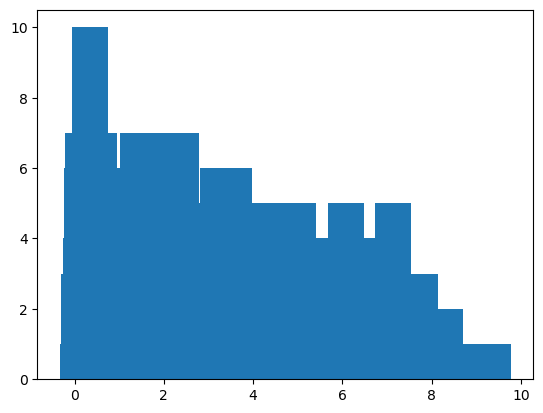

In [87]:
plt.bar(edges[:-1],hist)

In [41]:
tempo = 31.01
res = np.round((tempo-30)/2)
res, (res*2)+30

(1.0, 32.0)

In [77]:
tf = read_data('C:\\Users\\chris\\Downloads\\train_extra_tempobeats', extension='.tempo.gt')

In [78]:
tempi = [track['tempo'] for track in tf.values()]

In [79]:
tempi = np.asarray(list(map(lambda x: x[0] if len(x) == 1 or x[2] > 0.5 else x[1], tempi)))

In [80]:
hist = np.bincount(np.round((tempi-30)/4).astype(int), minlength=256//4)

<BarContainer object of 64 artists>

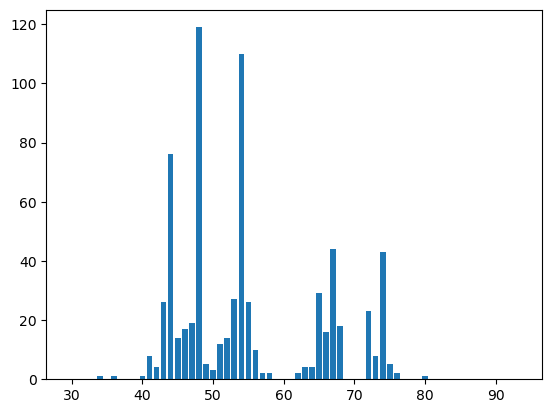

In [81]:
plt.bar(np.arange(30,256//4+30), hist)

<BarContainer object of 64 artists>

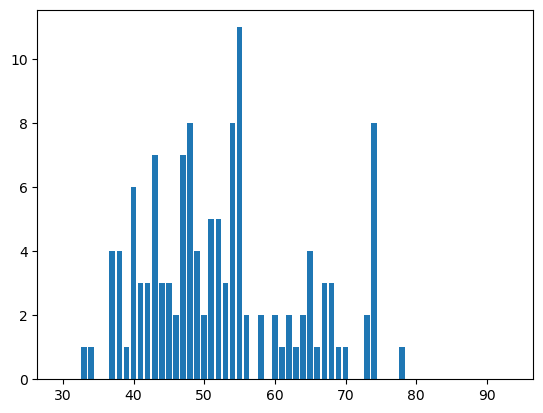

<BarContainer object of 256 artists>

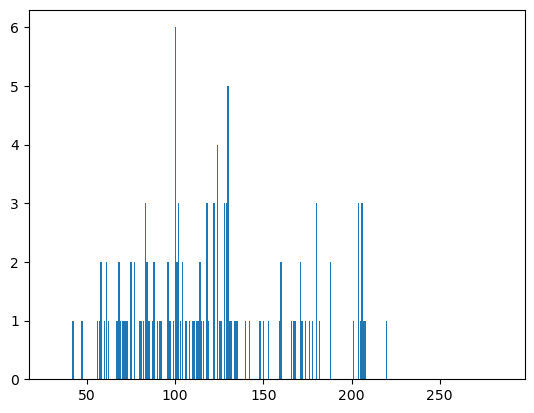

<BarContainer object of 256 artists>

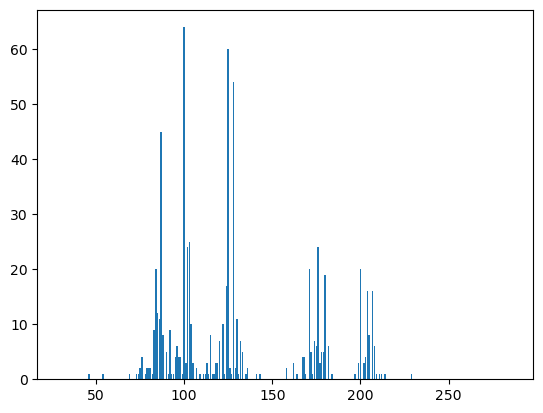

In [32]:
class DummyOptions():
    def __init__(self, pulse_width, multiplier, mfs=1, w1=3, w2=4, w3=3, w4=11, w5=0.01556, delta=0.08216):
        self.pulse_width = pulse_width
        self.multiplier = multiplier
        self.mfs = mfs
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5
        self.delta = delta
        self.plot = False

In [33]:
class Detector(BaseEstimator):
    def __init__(self, pulse_width=5, multiplier=1.8):
        super().__init__()
        self.pulse_width = pulse_width
        self.multiplier = multiplier
        
    def fit(self, X, Y):
        return self
    
    def predict(self, X):
        options = DummyOptions(self.pulse_width, self.multiplier)
        return [detect_everything(filename, options)['beats'] for filename in X]

In [34]:
def scorer(estimator, X, y):
    preds = estimator.predict(X)
    return sum(mir_eval.beat.f_measure(np.asarray(y[k]),
                                       np.asarray(preds[k]),
                                       0.07)
               for k in range(len(y))) / len(y)

In [35]:
source_dir = 'C:\\Users\\chris\\Downloads\\train_extra_tempobeats'

In [36]:
indir = Path(source_dir)
infiles = list(indir.glob('*.wav'))

In [37]:
truth_full = read_data(source_dir, extension='.gt')

In [38]:
truth = []
for filename in infiles:
    truth.append(truth_full[filename.name.rsplit('.', 1)[0]]['beats'])

In [39]:
len(truth) == len(infiles), len(truth)

(True, 696)

In [40]:
class ProgressBar():
    def __init__(self, total):
        self.progress_bar = tqdm(total=total)
        
    def __call__(self, result):
        self.progress_bar.update()
        self.progress_bar.set_postfix({'Best Score': -result.fun})
    
    def close(self):
        self.progress_bar.close()

In [57]:
search_space = {
    'pulse_width': (6, 8),
    'multiplier': (0.9, 1.6)
}

In [58]:
n_iter = 100
n_jobs = 7

search = BayesSearchCV(Detector(),
                       search_space,
                       scoring=scorer,
                       n_iter=n_iter,
                       n_jobs=n_jobs,
                       n_points=n_jobs,
                       refit=False,
                       random_state=42,
                       cv=[([], list(range(len(infiles))))]) # no training data, all in validation

search.fit(infiles, truth, callback=ProgressBar(int(np.ceil(n_iter/n_jobs))))

print("best score: %s" % search.best_score_)
print("best params: %s" % str(search.best_params_))

  7%|████▎                                                           | 1/15 [03:21<46:59, 201.39s/it, Best Score=0.503]C:\Users\chris\anaconda3\envs\music\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 40%|█████████████████████████▌                                      | 6/15 [19:37<29:19, 195.46s/it, Best Score=0.503]C:\Users\chris\anaconda3\envs\music\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
100%|███████████████████████████████████████████████████████████████| 15/15 [48:19<00:00, 178.81s/it, Best Score=0.503]

best score: 0.5034825737918911
best params: OrderedDict([('multiplier', 1.1870727711973197), ('pulse_width', 7)])


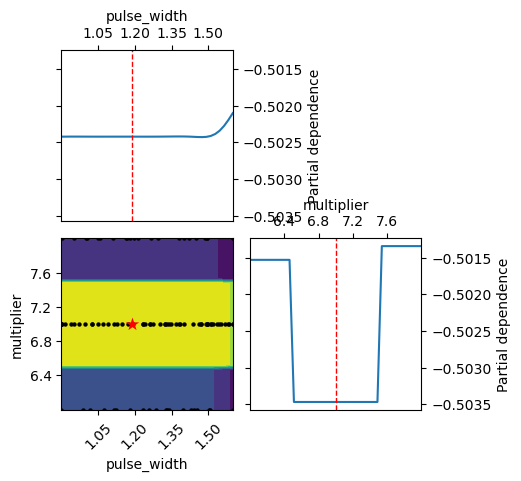

In [59]:
_ = plot_objective(search.optimizer_results_[0],
                   dimensions=list(search_space.keys()),
                   n_minimum_search=int(1e8))
plt.show()

In [50]:
with open('test_onsets.json', 'r') as f:
    test_tempos = json.load(f)
    
with open('final_predictions.json', 'r') as f:
    final_tempos = json.load(f)

In [51]:
names = list(test_tempos.keys())

In [52]:
v = 'onsets'
test = [test_tempos[n][v] for n in names]
final = [final_tempos[n][v] for n in names]

In [48]:
test[:10]

In [48]:
final[:10]

[[70.0, 140.0],
 [51.22, 102.44],
 [37.5, 75.0],
 [41.18, 82.35],
 [30.43, 60.87],
 [65.62, 131.25],
 [87.5, 175.0],
 [63.64, 127.27],
 [91.3, 182.61],
 [80.77, 161.54]]

In [56]:
all([np.allclose(a, b) for a, b in zip(test, final)])

ValueError: operands could not be broadcast together with shapes (69,) (87,) 

In [54]:
np.allclose(np.asarray(test), np.asarray(final))

C:\Users\chris\AppData\Local\Temp\ipykernel_19420\3252335128.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.allclose(np.asarray(test), np.asarray(final))


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''